In [1]:
# Import the modules
import numpy as np
import pandas as pd

from pathlib import Path
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

# Import the Data from the SQLite Database and Place in Dataframe

In [2]:
# Create Engine
engine = create_engine("sqlite:///lifestyle_sleep_data.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

# Save reference to the table
Sleep = Base.classes.lifestyle_sleep_data

In [3]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [4]:
# Query All Records in the the Database
sleep_df = pd.read_sql("SELECT * FROM lifestyle_sleep_data", conn)
#sleep_df=sleep_df.drop(columns = "person_id")
sleep_df.head()

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,BMI_category,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,diastolic_blood_pressure
0,0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [5]:
#Drop the person_id column
sleep_df=sleep_df.drop(columns = "person_id")
sleep_df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,BMI_category,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,diastolic_blood_pressure
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [6]:
# Get all data types
sleep_df.dtypes

gender                       object
age                           int64
occupation                   object
sleep_duration              float64
quality_of_sleep              int64
physical_activity_level       int64
stress_level                  int64
BMI_category                 object
heart_rate                    int64
daily_steps                   int64
sleep_disorder               object
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
dtype: object

In [ ]:
# Split 'blood_pressure' on '/' into two seperate columns and convert to integers.
#sleep_df[['systolic_blood_pressure', 'diastolic_blood_pressure']] = sleep_df['blood_pressure'].str.split('/', n=1, expand= True)
#sleep_df = sleep_df.drop(columns = 'blood_pressure')
#sleep_df = sleep_df.astype({'systolic_blood_pressure': int, 'diastolic_blood_pressure': int})
#sleep_df.head()

# Preprocess Data for Model

In [7]:
# Verify the categories of the "occupation" column
sleep_df['occupation'].value_counts()

Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: occupation, dtype: int64

In [8]:
# Clean up occupation category.
sleep_df['occupation'] = sleep_df['occupation'].replace({'Software Engineer': 'Other', 
                                                         'Scientist': "Other", 
                                                         'Sales Representative': 'Other', 
                                                         'Manager':'Other'})

In [9]:
# Verify clean-up
sleep_df['occupation'].value_counts()

Nurse          73
Doctor         71
Engineer       63
Lawyer         47
Teacher        40
Accountant     37
Salesperson    32
Other          11
Name: occupation, dtype: int64

In [10]:
# Transform the occupation column using get_dummies
occupation_dummies = pd.get_dummies(sleep_df['occupation'])

# Concatenate the sleep_df and the occupation_dummies DataFrames
sleep_df = pd.concat([sleep_df, occupation_dummies], axis=1)

# Drop the original occupation column
sleep_df =sleep_df.drop(columns=["occupation"])

# Display the DataFrame
sleep_df.head()


,gender,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,BMI_category,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,diastolic_blood_pressure,Accountant,Doctor,Engineer,Lawyer,Nurse,Other,Salesperson,Teacher
0,Male,27,6.1,6,42,6,Overweight,77,4200,None,126,83,0,0,0,0,0,1,0,0
1,Male,28,6.2,6,60,8,Normal,75,10000,None,125,80,0,1,0,0,0,0,0,0
2,Male,28,6.2,6,60,8,Normal,75,10000,None,125,80,0,1,0,0,0,0,0,0
3,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,0,0,0,0,0,1,0,0
4,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,0,0,0,0,0,1,0,0


In [11]:
# Verify the categories of the "BMI_category" column
sleep_df['BMI_category'].value_counts()

Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: BMI_category, dtype: int64

In [12]:
# Clean-up the "BMI-category"
sleep_df["BMI_category"] = sleep_df["BMI_category"].replace({'Normal': 'Normal Weight', 'Obese': 'Overweight'})

In [13]:
# Verify clean-up
sleep_df['BMI_category'].value_counts()

Normal Weight    216
Overweight       158
Name: BMI_category, dtype: int64

In [14]:
# Transform the "BMI_category" column using get_dummies
bmi_dummies = pd.get_dummies(sleep_df['BMI_category'])

# Concatenate the sleep_df and the bmi_dummies DataFrames
sleep_df = pd.concat([sleep_df, bmi_dummies], axis=1)

# Drop the original "BMI_category"  column
sleep_df =sleep_df.drop(columns=["BMI_category"])

# Display the DataFrame
sleep_df.head()


,gender,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,...,Accountant,Doctor,Engineer,Lawyer,Nurse,Other,Salesperson,Teacher,Normal Weight,Overweight
0,Male,27,6.1,6,42,6,77,4200,None,126,...,0,0,0,0,0,1,0,0,0,1
1,Male,28,6.2,6,60,8,75,10000,None,125,...,0,1,0,0,0,0,0,0,1,0
2,Male,28,6.2,6,60,8,75,10000,None,125,...,0,1,0,0,0,0,0,0,1,0
3,Male,28,5.9,4,30,8,85,3000,Sleep Apnea,140,...,0,0,0,0,0,1,0,0,0,1
4,Male,28,5.9,4,30,8,85,3000,Sleep Apnea,140,...,0,0,0,0,0,1,0,0,0,1


In [15]:
# Verify the values of the "gender" column
sleep_df['gender'].value_counts()

Male      189
Female    185
Name: gender, dtype: int64

In [16]:
# Transform the "gender" column using get_dummies
gender_dummies = pd.get_dummies(sleep_df['gender'])

# Concatenate the sleep_df and the gender_dummies DataFrames
sleep_df = pd.concat([sleep_df, gender_dummies], axis=1)

# Drop the original "gender" column
sleep_df =sleep_df.drop(columns=["gender"])

# Display the DataFrame
sleep_df.head()

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,diastolic_blood_pressure,...,Engineer,Lawyer,Nurse,Other,Salesperson,Teacher,Normal Weight,Overweight,Female,Male
0,27,6.1,6,42,6,77,4200,None,126,83,...,0,0,0,1,0,0,0,1,0,1
1,28,6.2,6,60,8,75,10000,None,125,80,...,0,0,0,0,0,0,1,0,0,1
2,28,6.2,6,60,8,75,10000,None,125,80,...,0,0,0,0,0,0,1,0,0,1
3,28,5.9,4,30,8,85,3000,Sleep Apnea,140,90,...,0,0,0,1,0,0,0,1,0,1
4,28,5.9,4,30,8,85,3000,Sleep Apnea,140,90,...,0,0,0,1,0,0,0,1,0,1


In [17]:
# Verify the values of the "sleep_disorder" column
sleep_df['sleep_disorder'].value_counts()

None           219
Sleep Apnea     78
Insomnia        77
Name: sleep_disorder, dtype: int64

In [18]:
# Clean-up the "sleep_disorder" column
sleep_df["sleep_disorder"] = sleep_df["sleep_disorder"].replace({'Sleep Apnea': 'Sleep Disorder', 'Insomnia': 'Sleep Disorder'})
# Verify the values of the "sleep_disorder" column
sleep_df['sleep_disorder'].value_counts()

None              219
Sleep Disorder    155
Name: sleep_disorder, dtype: int64

In [19]:
# Encoding the sleep_disorder column using a custom function
def encode_disorder(disorder):
    """
    This function encodes sleep disorder status by setting sleep apnea as 1 and none as 0.
    """
    if disorder == "Sleep Disorder":
        return 1
    else:
        return 0

# Call the encode_marriage function on the marriage column
sleep_df["sleep_disorder"] = sleep_df["sleep_disorder"].apply(encode_disorder)

# Review the DataFrame 
sleep_df.head()

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,sleep_disorder,systolic_blood_pressure,diastolic_blood_pressure,...,Engineer,Lawyer,Nurse,Other,Salesperson,Teacher,Normal Weight,Overweight,Female,Male
0,27,6.1,6,42,6,77,4200,0,126,83,...,0,0,0,1,0,0,0,1,0,1
1,28,6.2,6,60,8,75,10000,0,125,80,...,0,0,0,0,0,0,1,0,0,1
2,28,6.2,6,60,8,75,10000,0,125,80,...,0,0,0,0,0,0,1,0,0,1
3,28,5.9,4,30,8,85,3000,1,140,90,...,0,0,0,1,0,0,0,1,0,1
4,28,5.9,4,30,8,85,3000,1,140,90,...,0,0,0,1,0,0,0,1,0,1


# Split the Data into Training and Testing Sets

In [20]:
# Seperate the features, X,  from the target variable, y
y = sleep_df['sleep_disorder']
X = sleep_df.drop(columns='sleep_disorder')

In [21]:
# Preview the features data
X.head()

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,systolic_blood_pressure,diastolic_blood_pressure,Accountant,...,Engineer,Lawyer,Nurse,Other,Salesperson,Teacher,Normal Weight,Overweight,Female,Male
0,27,6.1,6,42,6,77,4200,126,83,0,...,0,0,0,1,0,0,0,1,0,1
1,28,6.2,6,60,8,75,10000,125,80,0,...,0,0,0,0,0,0,1,0,0,1
2,28,6.2,6,60,8,75,10000,125,80,0,...,0,0,0,0,0,0,1,0,0,1
3,28,5.9,4,30,8,85,3000,140,90,0,...,0,0,0,1,0,0,0,1,0,1
4,28,5.9,4,30,8,85,3000,140,90,0,...,0,0,0,1,0,0,0,1,0,1


In [22]:
# Preview the first five entries for the target variable
y[:5]

0    0
1    0
2    0
3    1
4    1
Name: sleep_disorder, dtype: int64

In [23]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

## Create Scaler and Scaled X training and Testing Data

In [24]:
 # Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Create a Logistic Regression Model 

In [25]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

## Predictions

In [26]:
# Make a prediction using the testing data
testing_predictions = logistic_regression_model.predict(X_test_scaled)
pd.DataFrame({"Prediction": testing_predictions, "Actual": y_test}).head()

,Prediction,Actual
342,0,0
256,1,1
226,1,1
317,0,0
288,1,1


## Accuracy Score

In [27]:
# Print the balanced_accuracy score of the model
balanced_accuracy_score(y_test, testing_predictions)


0.9177156177156177

## Confusion Matrix

In [28]:
# Generate a confusion matrix for the model
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[53  2]
 [ 5 34]]


## Classification Report

In [29]:
# Print the classification report for the model
target_names = ['No Sleep Disorder', "Sleep Disorder"]
testing_report = classification_report(y_test, testing_predictions, target_names = target_names)

# Print the testing classification report
print(testing_report)

                   precision    recall  f1-score   support

No Sleep Disorder       0.91      0.96      0.94        55
   Sleep Disorder       0.94      0.87      0.91        39

         accuracy                           0.93        94
        macro avg       0.93      0.92      0.92        94
     weighted avg       0.93      0.93      0.93        94



## Create a Decision Tree Model

In [30]:
 # Creating the decision tree classifier instance
tree_model = tree.DecisionTreeClassifier()

In [31]:
# Fitting the model
tree_model = tree_model.fit(X_train_scaled, y_train)

In [32]:
# Making predictions using the testing data
tree_predictions = tree_model.predict(X_test_scaled)

In [33]:
# Calculating the confusion matrix
tree_cm = confusion_matrix(y_test, tree_predictions)
tree_cm_df = pd.DataFrame(
    tree_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
tree_acc_score = balanced_accuracy_score(y_test, tree_predictions)

In [34]:
 # Displaying results
print("Confusion Matrix")
display(tree_cm_df)
print(f"Accuracy Score : {tree_acc_score}")
print("Classification Report")
print(classification_report(y_test, tree_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,53,2
Actual 1,5,34


Accuracy Score : 0.9177156177156177
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        55
           1       0.94      0.87      0.91        39

    accuracy                           0.93        94
   macro avg       0.93      0.92      0.92        94
weighted avg       0.93      0.93      0.93        94



## Create a Random Forest Model

In [35]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [36]:
 # Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [37]:
# Making predictions using the testing data
random_predictions = rf_model.predict(X_test_scaled)

In [38]:
# Calculating the confusion matrix
random_cm = confusion_matrix(y_test, random_predictions)
random_cm_df = pd.DataFrame(
    random_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
random_acc_score = balanced_accuracy_score(y_test, random_predictions)

In [39]:
 # Displaying results
print("Confusion Matrix")
display(random_cm_df)
print(f"Accuracy Score : {random_acc_score}")
print("Classification Report")
print(classification_report(y_test, random_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,53,2
Actual 1,5,34


Accuracy Score : 0.9177156177156177
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        55
           1       0.94      0.87      0.91        39

    accuracy                           0.93        94
   macro avg       0.93      0.92      0.92        94
weighted avg       0.93      0.93      0.93        94



# Feature Importance

In [40]:
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.19990940010776037, 'Normal Weight'),
 (0.18881084770921536, 'Overweight'),
 (0.15956472037789365, 'systolic_blood_pressure'),
 (0.10009377674776927, 'diastolic_blood_pressure'),
 (0.08525223330503487, 'sleep_duration'),
 (0.08002536970387293, 'age'),
 (0.02860892055935214, 'heart_rate'),
 (0.02574222427448477, 'Nurse'),
 (0.023786507697952767, 'daily_steps'),
 (0.02200905676613037, 'quality_of_sleep'),
 (0.021368520407417907, 'stress_level'),
 (0.01648764928200455, 'physical_activity_level'),
 (0.010288267588705904, 'Salesperson'),
 (0.008679650593686824, 'Doctor'),
 (0.006777289263406543, 'Engineer'),
 (0.006162469735040539, 'Lawyer'),
 (0.005603855560472262, 'Male'),
 (0.005352065486859789, 'Female'),
 (0.0031097209063165525, 'Other'),
 (0.002045560370287377, 'Teacher'),
 (0.0003218935563352317, 'Accountant')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

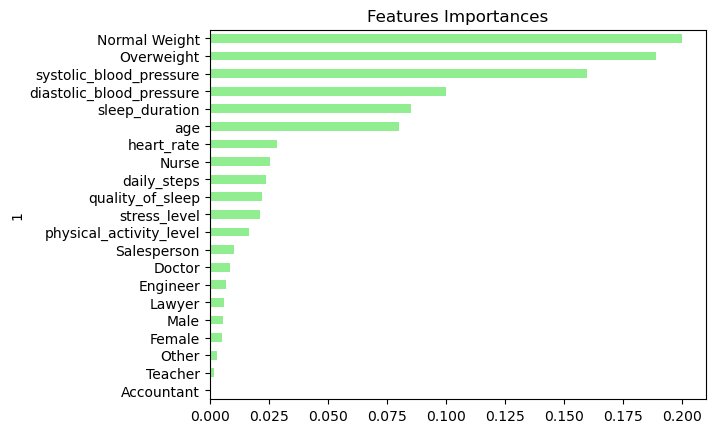

In [41]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [42]:
session.close()